In [1]:
import math
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # lineaBLUEr algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rnd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imports:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
 
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
 
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier


# Read data:
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')
#combine = {"train_df": train_df, "test_df": test_df}


# Pre-processing

In [2]:
# Drop irrelevant coulomns
train_df.drop(columns=['PassengerId', 'Ticket', 'Fare', 'Embarked', 'Cabin'], inplace=True)
test_df.drop(columns=['PassengerId', 'Ticket', 'Fare', 'Embarked', 'Cabin'], inplace=True)

In [3]:
# Turn 'Sex' coulmn to 0,1 numeric values 
train_df['Sex'].replace({'male': 1, 'female': 0}, inplace=True)
test_df['Sex'].replace({'male': 1, 'female': 0}, inplace=True)

In [4]:
# Functions that gets a Pandas dataframe with column 'Name'
# and extracts a title from the name (only extract TOP 4 main titles)
# @param: df (pd.DataFrame) with column 'Name'
# @return: df (pd.DataFrame)
def getTitle(df: pd.DataFrame) -> pd.DataFrame:
    for r in df['Name']:
        if "Mr." in r:
            df['Name'].replace(r, "Mr.", inplace=True)  # 517 occurrences in train_df
        elif "Mrs." in r:
            df['Name'].replace(r, "Mrs.", inplace=True)  # 125 occurrences in train_df
        elif "Miss." in r:
            df['Name'].replace(r, "Miss.", inplace=True)  # 182 occurrences in train_df
        elif "Master" in r:
            df['Name'].replace(r, "Master", inplace=True)  # 40 occurrences in train_df
        else:  # 27 occurrences in train_df
            df['Name'].replace(r, "Other", inplace=True)
    df.rename(columns={'Name':'Title'}, inplace=True)
    return df

# Call dataframes to getTitle function
train_df = getTitle(train_df)
test_df = getTitle(test_df)


    # # Functions that gets a Pandas dataframe with column 'Name'
    # # and extracts a title from the name (extract ALL possible titles)
    # # @param: df (pd.DataFrame) with column 'Name'
    # # @return: df (pd.DataFrame)
    # def getTitle_fullSplit(df: pd.DataFrame) -> pd.DataFrame:
    #     import re
    #     for row in df["Name"]:
    #         title = re.search(", [A-Za-z\s]+\.", row).group()  
    #         title = re.sub(r'[^a-zA-Z]', '', title)
    #         df["Name"].replace(row, title, inplace=True) 
    #     df.rename(columns={'Name':'Title'}, inplace=True)
    #     return df

    # # Call dataframes to getTitle_fullSplit function
    # train_df = getTitle_fullSplit(train_df)
    # test_df = getTitle_fullSplit(test_df)

In [5]:
# Split the categorical column 'title' into true/false columns, 
# each column represents a diffrenet title.  
train_df = pd.concat([train_df, pd.get_dummies(train_df['Title'])], axis=1)
train_df.drop(columns=['Title'], inplace=True)
test_df = pd.concat([test_df, pd.get_dummies(test_df['Title'])], axis=1)
test_df.drop(columns=['Title'], inplace=True)

# # Change each title to numeric value
# train_df['Title'].replace({'Mr.': 0, 'Mrs.': 1, "Miss.": 2, "Master": 3, "Other": 4}, inplace=True)
# test_df['Title'].replace({'Mr.': 0, 'Mrs.': 1, "Miss.": 2, "Master": 3, "Other": 4}, inplace=True)


# train_df.head()

### fill missing values in age with mean of the relevant Pclass and Age

In [6]:
def fillna_age(df: pd.DataFrame) -> pd.DataFrame:
    # Calculate all relevant means values of each Pclass by Sex in df
    p1_women_mean = df[(df["Pclass"] == 1) & (df["Sex"] == 0)]["Age"].mean()
    p1_men_mean = df[(df["Pclass"] == 1) & (df["Sex"] == 1)]["Age"].mean()
    p2_women_mean = df[(df["Pclass"] == 2) & (df["Sex"] == 0)]["Age"].mean()
    p2_men_mean = df[(df["Pclass"] == 2) & (df["Sex"] == 1)]["Age"].mean()
    p3_women_mean = df[(df["Pclass"] == 3) & (df["Sex"] == 0)]["Age"].mean()
    p3_men_mean = df[(df["Pclass"] == 3) & (df["Sex"] == 1)]["Age"].mean()
    
    # set missing NaN values according to relevant Pclass by Sex
    df.loc[(df["Pclass"] == 1) & (df["Sex"] == 0), "Age"] = df.loc[(df["Pclass"] == 1) & (df["Sex"] == 0), "Age"].apply(lambda x: x if not np.isnan(x) else p1_women_mean)
    df.loc[(df["Pclass"] == 1) & (df["Sex"] == 1), "Age"] = df.loc[(df["Pclass"] == 1) & (df["Sex"] == 1), "Age"].apply(lambda x: x if not np.isnan(x) else p1_men_mean)
    df.loc[(df["Pclass"] == 2) & (df["Sex"] == 0), "Age"] = df.loc[(df["Pclass"] == 2) & (df["Sex"] == 0), "Age"].apply(lambda x: x if not np.isnan(x) else p2_women_mean)
    df.loc[(df["Pclass"] == 2) & (df["Sex"] == 1), "Age"] = df.loc[(df["Pclass"] == 2) & (df["Sex"] == 1), "Age"].apply(lambda x: x if not np.isnan(x) else p2_men_mean)
    df.loc[(df["Pclass"] == 3) & (df["Sex"] == 0), "Age"] = df.loc[(df["Pclass"] == 3) & (df["Sex"] == 0), "Age"].apply(lambda x: x if not np.isnan(x) else p3_women_mean)
    df.loc[(df["Pclass"] == 3) & (df["Sex"] == 1), "Age"] = df.loc[(df["Pclass"] == 3) & (df["Sex"] == 1), "Age"].apply(lambda x: x if not np.isnan(x) else p3_men_mean)

    return df
    
train_df = fillna_age(train_df)
test_df = fillna_age(test_df)


    # # --This options disregards the Sex of the passanger--
    # # Testing have found that this gets lower scores when running the models

    # def fillna_age(df: pd.DataFrame) -> pd.DataFrame:
    #     # Calculate all relevant means values of each Pclass in df
    #     p1_mean = df[df["Pclass"] == 1]["Age"].mean()
    #     p2_mean = df[df["Pclass"] == 2]["Age"].mean()
    #     p3_mean = df[df["Pclass"] == 3]["Age"].mean()

    #     # set missing NaN values according to relevant Pclass
    #     df.loc[df["Pclass"] == 1, "Age"] = df.loc[df["Pclass"] == 1, "Age"].apply(lambda x: x if not np.isnan(x) else p1_mean)
    #     df.loc[df["Pclass"] == 2, "Age"] = df.loc[df["Pclass"] == 2, "Age"].apply(lambda x: x if not np.isnan(x) else p2_mean)
    #     df.loc[df["Pclass"] == 3, "Age"] = df.loc[df["Pclass"] == 3, "Age"].apply(lambda x: x if not np.isnan(x) else p3_mean)

    #     return df

    # train_df = fillna_age(train_df)
    # test_df = fillna_age(test_df)

train_df.head(10)
# Notice passanger with ID == 5 got his Age set with the avarege of all 3rd class male passanger.

,Survived,Pclass,Sex,Age,SibSp,Parch,Master,Miss.,Mr.,Mrs.,Other
0,0,3,1,22.000000,1,0,0,0,1,0,0
1,1,1,0,38.000000,1,0,0,0,0,1,0
2,1,3,0,26.000000,0,0,0,1,0,0,0
3,1,1,0,35.000000,1,0,0,0,0,1,0
4,0,3,1,35.000000,0,0,0,0,1,0,0
5,0,3,1,26.507589,0,0,0,0,1,0,0
6,0,1,1,54.000000,0,0,0,0,1,0,0
7,0,3,1,2.000000,3,1,1,0,0,0,0
8,1,3,0,27.000000,0,2,0,0,0,1,0
9,1,2,0,14.000000,1,0,0,0,0,1,0


### Test Correlations

In [7]:
# # Test correlation between 'Survives' and 'Title'
# train_df[["Title", "Survived"]].groupby('Title', as_index=False).mean().sort_values(by="Survived", ascending=False)
# # --> Low correlation between tags (of same gender) and survival

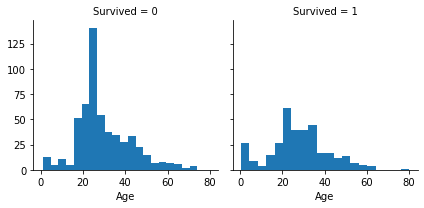

In [8]:
# Test correlation between 'Survives' and 'Age'
g = sns.FacetGrid(train_df, col = "Survived")
g.map(plt.hist, "Age", bins=20)
# --> Medium correlation (Babies and young adults are more likely to survive)

In [9]:
# Test correlation between 'Survives' and 'Sex'
train_df[["Sex", "Survived"]].groupby("Sex", as_index=False).mean().sort_values(by="Survived", ascending=False)
# --> Female passengers are more likely to survive

,Sex,Survived
0,0,0.742038
1,1,0.188908


In [10]:
# Test correlation between 'Survives' and 'SibSp'
train_df[["SibSp", "Survived"]].groupby('SibSp', as_index=False).mean().sort_values(by="Survived", ascending=False)
# --> High correlation (low sibSp means higher rates of surviving)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [11]:
# Test correlation between 'Survives' and 'Parch'
train_df[["Parch", "Survived"]].groupby('Parch', as_index=False).mean().sort_values(by="Survived", ascending=False)
# --> No correlation

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [12]:
# Test correlation between 'Survives' and 'Pclass'
train_df[["Pclass", "Survived"]].groupby('Pclass', as_index=False).mean().sort_values(by="Survived", ascending=False)
# --> High correlation (Better survival rates for higher class passangers)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [13]:
# Test correlation between 'Survives' and 'Relatives'
train_df['Relatives'] = train_df["SibSp"] + train_df["Parch"]
train_df[["Relatives", "Survived"]].groupby('Relatives', as_index=False).mean().sort_values(by="Survived", ascending=False)
test_df['Relatives'] = test_df["SibSp"] + test_df["Parch"]
train_df[["Relatives", "Survived"]].groupby('Relatives', as_index=False).mean().sort_values(by="Survived", ascending=False)
# --> No correlation

,Relatives,Survived
3,3,0.724138
2,2,0.578431
1,1,0.552795
6,6,0.333333
0,0,0.303538
4,4,0.200000
5,5,0.136364
7,7,0.000000
8,10,0.000000


### **Drop coulms with low correlation with Survived**

In [14]:
# train_df.drop(["Marital Status","Parch", "Relatives"], axis=1, inplace=True)
# test_df.drop(["Marital Status","Parch", "Relatives"], axis=1, inplace=True)
train_df.drop(["Parch", "Relatives"], axis=1, inplace=True)
test_df.drop(["Parch", "Relatives"], axis=1, inplace=True)

# Run models:

In [15]:
#LogisticRegression
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.copy()
X_train.shape, Y_train.shape, X_test.shape
logreg = LogisticRegression(max_iter=300)
logreg.fit(X_train, Y_train)
Y_pred_LR = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

82.94

In [16]:
#random_forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred_RF = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100,2)
acc_random_forest

91.58

### Save results to file

In [17]:
# Get the PassengerId column from the original csv
test_df_IDs = pd.read_csv('./input/test.csv')
# Create a submission dataframe
my_submission = pd.DataFrame({'PassengerId': test_df_IDs['PassengerId'], 'Survived': Y_pred_LR})
# Save the submission as .csv file
my_submission.to_csv('./output/submission.csv', index=False)